In [1]:
from skimage import (
    segmentation,
    filters,
    img_as_ubyte,
    img_as_float,
    img_as_uint,
    io,
    morphology,
    measure,
)
from cell_counting_analysis import cell_counting_analysis as cca
from cell_counting_analysis import seg_and_bin, timeseries
import trackpy
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

### process a1 sample

In [50]:
a1_sample_name = "a1g3"

In [51]:
a1_sample_C0 = img_as_float(
    io.imread(f"../Average_Proj_Stack/{a1_sample_name}_C0.tiff")
)
a1_sample_C1 = img_as_float(
    io.imread(f"../Average_Proj_Stack/{a1_sample_name}_C1.tiff")
)

In [52]:
a1_sample_C0_lab = [
    seg_and_bin.watershed_binary_img_to_labelled_img(
        seg_and_bin.gaussian_threshold_remove_small_objects_and_holes(
            a1_sample_C0[z, :, :],
            filters.threshold_li,
            gaussian_sigma=2,
            tolerance=0.1,
        ),
        gaussian_sigma=2,
    )
    for z in range(a1_sample_C0.shape[0])
]

In [53]:
a1_feature_df = timeseries.stack_label_images_to_tidy_df(
    a1_sample_C0_lab, a1_sample_C1, a1_sample_C0
)

In [54]:
a1_linked_df = trackpy.link_df(a1_feature_df, 10)

Frame 30: 97 trajectories present.


In [55]:
a1_filt_df = timeseries.keep_particles_through_stack(a1_linked_df)

22 in initial list
97 in final list
5 in common list


In [56]:
def model_func(f, a, k, b):
    return a * np.exp(-k * f) + b

In [57]:
a1_filt_df = pd.merge(
    a1_filt_df,
    (
        a1_filt_df.query("frame > 0 & frame < 5 | frame > 25")
        .groupby("particle")
        .apply(
            lambda x: curve_fit(
                model_func, x["frame"], x["mean_intensity_num_denom"], maxfev=10000
            )[0]
        )
    ).reset_index(name="model_params"),
    on="particle",
)

In [58]:
a1_filt_df["model"] = a1_filt_df.apply(
    lambda x: model_func(
        x["frame"], x["model_params"][0], x["model_params"][1], x["model_params"][2]
    ),
    axis=1,
)
a1_filt_df["mean_intensity_num_denom_model"] = (
    a1_filt_df["mean_intensity_num_denom"] / a1_filt_df["model"]
)

### process o1 sample

In [59]:
o1_sample_name = "o1g3"

In [60]:
o1_sample_C0 = img_as_float(
    io.imread(f"../Average_Proj_Stack/{o1_sample_name}_C0.tiff")
)
o1_sample_C1 = img_as_float(
    io.imread(f"../Average_Proj_Stack/{o1_sample_name}_C1.tiff")
)

In [61]:
o1_sample_C0_lab = [
    seg_and_bin.watershed_binary_img_to_labelled_img(
        seg_and_bin.gaussian_threshold_remove_small_objects_and_holes(
            o1_sample_C0[z, :, :],
            filters.threshold_li,
            gaussian_sigma=2,
            tolerance=0.1,
        ),
        gaussian_sigma=2,
    )
    for z in range(o1_sample_C0.shape[0])
]

In [62]:
o1_feature_df = timeseries.stack_label_images_to_tidy_df(
    o1_sample_C0_lab, o1_sample_C1, o1_sample_C0
)

In [63]:
o1_linked_df = trackpy.link_df(o1_feature_df, 10)

Frame 30: 31 trajectories present.


In [64]:
o1_filt_df = timeseries.keep_particles_through_stack(o1_linked_df)

30 in initial list
31 in final list
17 in common list


In [65]:
def model_func(f, a, k, b):
    return a * np.exp(-k * f) + b

In [66]:
o1_filt_df = pd.merge(
    o1_filt_df,
    (
        o1_filt_df.query("frame > 0 & frame < 5 | frame > 25")
        .groupby("particle")
        .apply(
            lambda x: curve_fit(
                model_func, x["frame"], x["mean_intensity_num_denom"], maxfev=10000
            )[0]
        )
    ).reset_index(name="model_params"),
    on="particle",
)

In [67]:
o1_filt_df["model"] = o1_filt_df.apply(
    lambda x: model_func(
        x["frame"], x["model_params"][0], x["model_params"][1], x["model_params"][2]
    ),
    axis=1,
)
o1_filt_df["mean_intensity_num_denom_model"] = (
    o1_filt_df["mean_intensity_num_denom"] / o1_filt_df["model"]
)

### combine a1 and o1 filt_dfs

In [68]:
a1_filt_df["particle"] = a1_filt_df["particle"].astype(str)
a1_filt_df["particle"] = "a1_" + a1_filt_df["particle"]

o1_filt_df["particle"] = o1_filt_df["particle"].astype(str)
o1_filt_df["particle"] = "o1_" + o1_filt_df["particle"]

In [69]:
a1_filt_df["age"] = "young"
o1_filt_df["age"] = "old"

In [70]:
a1o1_filt = pd.concat([a1_filt_df, o1_filt_df])

In [71]:
a1o1_filt["frame"] = a1o1_filt["frame"] - 1
a1o1_filt = a1o1_filt.query("frame > -1")

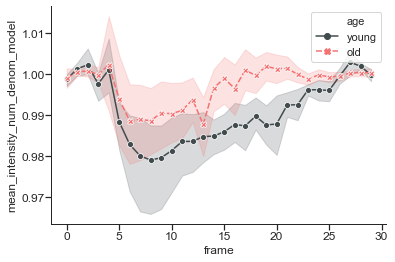

In [72]:
sns.set(
    context="notebook",
    style="ticks",
    palette="deep",
    font="arial",
    font_scale=1,
    color_codes=True,
    rc=None,
)

ax = sns.lineplot(
    x="frame",
    y="mean_intensity_num_denom_model",
    data=a1o1_filt,
    hue="age",
    style="age",
    markers=True,
    palette=["#414a4c", "#F57171"],
)

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

ax.tick_params(axis="both", which="major", pad=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.setp(ax.spines.values(), linewidth=1)
sns.despine()

plt.savefig(
    f"young_old_glucose_FRET_{a1_sample_name}_{o1_sample_name}.pdf",
    transparent=True,
    bbox_inches="tight",
)

sns.reset_orig()